# 2.1) 나무위키 최신 변경 문서의 키워드 분석
바로가기
* <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기
    * [BeautifulSoup을 이용한 웹 크롤링]
    * [나무위키 최근변경 데이터 크롤링]
* <Step2. 추출> : 키워드 추출
    * [텍스트 데이터 전처리]
    * [말뭉치 만들기]
    * [konlpy를 이용한 키워드 추출]
    * [키워드 가다듬기]
* <Step3. 시각화> : 워드 클라우드 시각화
    * [pytagcloud 사용하기]
    * [나무위키 키워드 시각화]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

# <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기

[BeautifulSoup을 이용한 웹 크롤링]

* 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    * (env_name) pip install requests
    * (env_name) pip install beautifulsoup4
    * (env_name) pip install lxml
* 혹은 아래의 코드로 라이브러리를 설치합니다.

In [2]:
!pip install requests beautifulsoup4 lxml

/bin/bash: /home/himmel/.local/bin/pip: /usr/local/bin/python3.9: bad interpreter: 그런 파일이나 디렉터리가 없습니다


# 페이지 리스트 가져오기

In [3]:
import requests
from bs4 import BeautifulSoup
import re

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [4]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)

# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

https://namu.wiki/w/%EA%B3%B5%EC%84%B1%20%EB%B3%91%EA%B8%B0
https://namu.wiki/w/%EA%B5%AC%ED%98%B8%EB%8F%99(%ED%8E%9C%ED%8A%B8%ED%95%98%EC%9A%B0%EC%8A%A4)
https://namu.wiki/w/%EA%B9%80%EB%91%90%ED%98%84
https://namu.wiki/w/%EC%98%A8%EC%BD%94%ED%94%84%EB%A6%AC%EC%8A%A4%ED%8B%B0%EC%8A%A4
https://namu.wiki/w/%EC%9C%A0%EA%B2%BD%EC%A4%80


# 페이지내 텍스트 구조 확인

In [5]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'html.parser')
contents_table = soup.find(name="article")
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
content_corpus_list = []

for paragraphs in content_paragraphs:
    content_corpus_list.append(paragraphs.text)
content_corpus = "".join(content_corpus_list)

print(title.text)
print("\n")
print(category.text)
print("\n")
print(content_corpus)

공성 병기 


공성전지상 병기/고대~근세기


1. 개요2. 전근대의 공성 병기2.1. 투석기(投石器)2.2. 공성포(攻城砲)2.3. 충차(衝車)2.4. 정란(井欄)2.5. 운제(雲梯)・제(梯; 사다리)2.6. 전호피차(塡壕皮車)2.7. 기타3. 근대의 공성 병기4. 현대의 공성 병기공성 병기(攻城兵器, Siege engine)는 성채나 방벽 등 적이 깔아 놓은 장애물을 포위하여 파괴하는 것이 주된 목표인 공성전(攻城戰)에서 쓰이는 병기를 말한다. 반의어는 수성 병기(守城兵器)이다.  자세한 내용은 투석기 문서를의 번째 문단을의  부분을 참고하십시오.공성과 수성 양 진영에서 모두 쓰이던 병기이다. 공성 병기로 쓰일 경우 성벽 자체를 부수거나 성벽 너머로 돌이나 화염을 날려 보내는 용도로, 수성 병기로 쓰일 경우 정란(공성탑)이나 진영을 무너뜨리는 용도로 사용되었다. 고대 중국에서는 포차(砲車), 포행차(砲行車), 발석거(發石車), 벽력거(霹靂車)라고도 불렸다.투석기캐터펄트트레뷰셋(회회포)발리스타(노포)  자세한 내용은 공성포 문서를의 번째 문단을의  부분을 참고하십시오.수원 화성의 홍이포 레플리카.화약이 병장기에 쓰이기 시작하며 개발된 무기. 위력면에서 보자면 투석기의 상위호환으로, 공성 병기이기도 했지만 성채에 설치하여 수성 병기로도 쓰였다.주로 성문을 부술 때 사용되었던 병기로, 공성추(攻城椎), 파성추(破城椎), 파성퇴(破城槌), 당차(撞車), 공성 망치 등으로도 불린다. 영어로는 '램(ram)', '배터링 램(battering ram)'이라고 한다. 본래 '램'은 숫양을 뜻하는 명사인데, 숫양이 분노했을 때 뿔로 들이받는 모습에서 무기의 이름을 따 온 것이다. 단순히 커다란 통나무[1]를 자르고 손잡이를 달아서 병사들이 이걸 직접 들고 돌격하는 것부터, 손잡이와 바퀴를 달아 밀고 가는것, 여기서 더 발달하면 병사들을 보호하기 위해 벽과 지붕을 가진 수레에 얹기도 한다. 지붕은 성문에서 던지는 돌을 미끄러뜨려버리기 위해 경사가 급한 삼각형으로 만들고, 

# [나무위키 최근변경 데이터 크롤링]

In [6]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 “분류”라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

# <Step2. 추출> : 키워드 추출

* 텍스트 데이터 전처리

In [7]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [8]:
print(text_cleaning(df['content_text'][0]))

 개요 전근대의 공성 병기 투석기 공성포 충차 정란 운제제 사다리 전호피차 기타 근대의 공성 병기 현대의 공성 병기공성 병기  는 성채나 방벽 등 적이 깔아 놓은 장애물을 포위하여 파괴하는 것이 주된 목표인 공성전에서 쓰이는 병기를 말한다 반의어는 수성 병기이다 자세한 내용은 투석기 문서를의 번째 문단을의  부분을 참고하십시오공성과 수성 양 진영에서 모두 쓰이던 병기이다 공성 병기로 쓰일 경우 성벽 자체를 부수거나 성벽 너머로 돌이나 화염을 날려 보내는 용도로 수성 병기로 쓰일 경우 정란공성탑이나 진영을 무너뜨리는 용도로 사용되었다 고대 중국에서는 포차 포행차 발석거 벽력거라고도 불렸다투석기캐터펄트트레뷰셋회회포발리스타노포 자세한 내용은 공성포 문서를의 번째 문단을의  부분을 참고하십시오수원 화성의 홍이포 레플리카화약이 병장기에 쓰이기 시작하며 개발된 무기 위력면에서 보자면 투석기의 상위호환으로 공성 병기이기도 했지만 성채에 설치하여 수성 병기로도 쓰였다주로 성문을 부술 때 사용되었던 병기로 공성추 파성추 파성퇴 당차 공성 망치 등으로도 불린다 영어로는 램 배터링 램 이라고 한다 본래 램은 숫양을 뜻하는 명사인데 숫양이 분노했을 때 뿔로 들이받는 모습에서 무기의 이름을 따 온 것이다 단순히 커다란 통나무를 자르고 손잡이를 달아서 병사들이 이걸 직접 들고 돌격하는 것부터 손잡이와 바퀴를 달아 밀고 가는것 여기서 더 발달하면 병사들을 보호하기 위해 벽과 지붕을 가진 수레에 얹기도 한다 지붕은 성문에서 던지는 돌을 미끄러뜨려버리기 위해 경사가 급한 삼각형으로 만들고 매체에서 묘사한 것을 보면 지붕에 가죽이나 금속판 등이 붙어 있는데 이건 화공을 방어하기 위한 것으로 미리 물을 뿌려두거나 물을 지참해서 틈틈이 뿌리는 식으로 대비하지만 그럼에도 불구하고 성문을 부수기 위해 한 자리에서 오랫동안 머물러 있어야만 하므로 불에는 아주 취약했다현대에 와서는 성을 부술 일은 없어졌으나 테러 진압 시 문을 부수고 들어갈 때 소형화한 도어 브리칭용 배터링 램이 이런 역할을 대신하고 

In [9]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,공성 병기,공성전지상 병기고대근세기,개요 전근대의 공성 병기 투석기 공성포 충차 정란 운제제 사다리 전호피차 기타 근...
1,구호동펜트하우스,박은석펜트하우스드라마등장인물,등장인물 주요인물심수련 가족심수련천서진오윤희주단태주석훈심수련 가족천서진 가족오윤...
2,김두현,년 출생대한민국의 축구선수동두천시 출신 인물대한민국의 아시안 게임 메달리스트웨스트 ...,은는 여기로 연결됩니다 동명의 작곡가에 대한 내용은 황금두현 문서를의 번 문단을...
3,온코프리스티스,온코프리스티스속고생물,온코프리스티스 분류계동물계문척삭동물문강연골어강아강판새아강상목가오리상목미...
4,유경준,제대 국회의원한국의 경제학자서울특별시 출신 인물년 출생교수박근혜 정부인사대한민국의 ...,대한민국 국회의원 서울 강남구 병제대이은재제대유경준현직 대한민국 통계청장 박근혜 ...


# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [10]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [11]:
print(text_cleaning(df['content_text'][0]))

 개요 전근대의 공성 병기 투석기 공성포 충차 정란 운제제 사다리 전호피차 기타 근대의 공성 병기 현대의 공성 병기공성 병기  는 성채나 방벽 등 적이 깔아 놓은 장애물을 포위하여 파괴하는 것이 주된 목표인 공성전에서 쓰이는 병기를 말한다 반의어는 수성 병기이다 자세한 내용은 투석기 문서를의 번째 문단을의  부분을 참고하십시오공성과 수성 양 진영에서 모두 쓰이던 병기이다 공성 병기로 쓰일 경우 성벽 자체를 부수거나 성벽 너머로 돌이나 화염을 날려 보내는 용도로 수성 병기로 쓰일 경우 정란공성탑이나 진영을 무너뜨리는 용도로 사용되었다 고대 중국에서는 포차 포행차 발석거 벽력거라고도 불렸다투석기캐터펄트트레뷰셋회회포발리스타노포 자세한 내용은 공성포 문서를의 번째 문단을의  부분을 참고하십시오수원 화성의 홍이포 레플리카화약이 병장기에 쓰이기 시작하며 개발된 무기 위력면에서 보자면 투석기의 상위호환으로 공성 병기이기도 했지만 성채에 설치하여 수성 병기로도 쓰였다주로 성문을 부술 때 사용되었던 병기로 공성추 파성추 파성퇴 당차 공성 망치 등으로도 불린다 영어로는 램 배터링 램 이라고 한다 본래 램은 숫양을 뜻하는 명사인데 숫양이 분노했을 때 뿔로 들이받는 모습에서 무기의 이름을 따 온 것이다 단순히 커다란 통나무를 자르고 손잡이를 달아서 병사들이 이걸 직접 들고 돌격하는 것부터 손잡이와 바퀴를 달아 밀고 가는것 여기서 더 발달하면 병사들을 보호하기 위해 벽과 지붕을 가진 수레에 얹기도 한다 지붕은 성문에서 던지는 돌을 미끄러뜨려버리기 위해 경사가 급한 삼각형으로 만들고 매체에서 묘사한 것을 보면 지붕에 가죽이나 금속판 등이 붙어 있는데 이건 화공을 방어하기 위한 것으로 미리 물을 뿌려두거나 물을 지참해서 틈틈이 뿌리는 식으로 대비하지만 그럼에도 불구하고 성문을 부수기 위해 한 자리에서 오랫동안 머물러 있어야만 하므로 불에는 아주 취약했다현대에 와서는 성을 부술 일은 없어졌으나 테러 진압 시 문을 부수고 들어갈 때 소형화한 도어 브리칭용 배터링 램이 이런 역할을 대신하고 

In [12]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,공성 병기,공성전지상 병기고대근세기,개요 전근대의 공성 병기 투석기 공성포 충차 정란 운제제 사다리 전호피차 기타 근...
1,구호동펜트하우스,박은석펜트하우스드라마등장인물,등장인물 주요인물심수련 가족심수련천서진오윤희주단태주석훈심수련 가족천서진 가족오윤...
2,김두현,년 출생대한민국의 축구선수동두천시 출신 인물대한민국의 아시안 게임 메달리스트웨스트 ...,은는 여기로 연결됩니다 동명의 작곡가에 대한 내용은 황금두현 문서를의 번 문단을...
3,온코프리스티스,온코프리스티스속고생물,온코프리스티스 분류계동물계문척삭동물문강연골어강아강판새아강상목가오리상목미...
4,유경준,제대 국회의원한국의 경제학자서울특별시 출신 인물년 출생교수박근혜 정부인사대한민국의 ...,대한민국 국회의원 서울 강남구 병제대이은재제대유경준현직 대한민국 통계청장 박근혜 ...


# 말뭉치 만들기

In [13]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

공성 병기 구호동펜트하우스 김두현 온코프리스티스 유경준  도쿄 올림픽 백호강사 월 일 틀미국의 대외전쟁 총재   타워 한국몬테네그로 관계 이세계 마법은 뒤떨어졌다  음반 사미라 무기스페셜 무기 산범 멜리오다스 레귤러 쇼 더 무비  솔브릿 킹 뵤겐 초현실 해방 전선 랜선 뽑기 둠바 러브 라이브 니지가사키 학원 스쿨 아이돌 동호회애니메이션에피소드 가이드    유언한국 창작물 추방자의 산맥몬스터  쿠레하 인싸 케이비판 북한몬테네그로 관계 게이밍 기어 심수창선수 경력 땅울림 아바타 아앙의 전설등장인물 라피스  월드 오브 워크래프트레벨 업 코스  강남구 병 마자파힛 제국 방탄소년단 티파탄       락다운 슈퍼 스매시브라더스 얼티밋 여고추리반 크램푸스 프리져     사탄근육맨 카를로스 테베스 틀터키의 대외전쟁 로건 리 천서진 한국 드라마 


# [konlpy를 이용한 키워드 추출]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
- 아래의 방법으로 설치해도 실행되지 않는다면, http://konlpy.org/ko/latest/install/ 를 참고하세요.
    - Install
        - 1. Java를 설치합니다. (https://java.com/ko/download/)
        - 2. c++ 컴파일러를 설치합니다. 
            - 윈도우 : `Microsoft Visual C++ 14.0` 설치 권장, https://visualstudio.microsoft.com/ko/downloads/
            - Mac OS : `Xcode` 설치 권장
            - Linux : `gcc` 설치 권장
        - 3. 아래와 같은 파이썬 패키지를 설치합니다. **konlpy 버전을 반드시 0.5.1로 해주어야 합니다. 2020년 현재(9월) 기준, 최신 버전 konlpy 에서는 일부 개발환경에서 자바 에러가 발생합니다.**
            - (env_name) `pip install konlpy==0.5.1`
            - (env_name) `pip install jpype1`
            - (env_name) `pip install Jpype1-py3`

In [14]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

AttributeError: module '_jpype' has no attribute '_JPackage'

In [15]:
count

Counter({'상위': 122,
         '문서': 1727,
         '힐라': 97,
         '메이플스토리': 17,
         '보스': 132,
         '몬스터': 96,
         '접기': 101,
         '필드': 67,
         '주니어': 5,
         '크림슨': 5,
         '피아': 6,
         '누스': 2,
         '에피': 2,
         '기타': 101,
         '엘리트': 4,
         '챔피언': 38,
         '및': 335,
         '콘텐츠': 31,
         '불꽃': 25,
         '늑대': 8,
         '헤카': 3,
         '톤': 24,
         '도로시': 2,
         '우르': 11,
         '스': 198,
         '아르': 20,
         '카누': 2,
         '일반': 240,
         '자쿰': 4,
         '혼테일': 2,
         '핑크': 19,
         '빈카웅': 2,
         '시그너': 2,
         '스파': 20,
         '풀라': 2,
         '투': 62,
         '스더스크듄켈': 2,
         '선택': 192,
         '렌루': 2,
         '타비': 2,
         '스반': 2,
         '피에르': 5,
         '블러디': 23,
         '퀸': 33,
         '룸': 13,
         '단장': 6,
         '진': 283,
         '반': 124,
         '레온': 17,
         '카이': 54,
         '럼': 16,
         '매그너스': 5,
         

# 키워드 가다듬기 

In [16]:
# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

뮤직': 1, '소리바다': 1, '옥집': 1, '헌책방': 1, '선풍기': 1, '옹기종기': 1, '사유리': 1, '군무': 1, '피크닉': 1, '박영진': 1, '박지선': 1, '명랑특급': 1, '피디': 1, '흥건': 1, '제반': 1, '아홉': 1, '칠전팔기': 1, '야후': 1, '외신': 1, '위대': 1, '쇼미더머니': 1, '기염': 1, '어워즈': 1, '거머쥐': 1, '상비': 1, '드비하인드': 1, '월초': 1, '차위년': 1, '가독성': 1, '외국산': 1, '베댓': 1, '난청': 1, '비기닝': 1, '등촌동': 1, '식구': 1, '신본기': 1, '민준': 1, '아트디렉터': 1, '절판': 1, '사석': 1, '고차': 1, '다이내믹': 1, '예일': 1, '정원규': 1, '장원': 1, '침낭': 1, '민원': 1, '인산인해': 1, '갤러가': 1, '불상': 1, '양일': 1, '텅텅': 1, '사복': 1, '볼법': 1, '겹악재': 1, '유모차': 1, '비질': 1, '특임': 1, '현용': 1, '고무줄': 1, '혈안': 1, '코코페': 1, '폭우': 1, '굴다리': 1, '더위': 1, '찜통': 1, '강압': 1, '독과점': 1, '꺠질': 1, '구세대': 1, '셨던': 1, '조문': 1, '장례식': 1, '동인': 1, '일요': 1, '해묵': 1, '딴지': 1, '불쾌': 1, '불매운동': 1, '리얼돌': 1, '무허가': 1, '갈라': 1, '인민해방군': 1, '소련군': 1, '나강': 1, '아헤': 1, '창궐': 1, '월월월월': 1, '범세계': 1, '전염병': 1, '다음해': 1, '과민': 1, '유의사항': 1, '위키아': 1, '그래프': 1, '튬콩슈': 1, '개틀링콩': 1, '물병': 1, '전나무': 1, '튕겨낸': 1, '닌자거북이': 1, '웃음꽃': 1, '수혜': 1, '튬챌

# 불용어 제거 

In [17]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [18]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [19]:
# 키워드 데이터에서 불용어를 제거합니다.
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

'국론': 1, '익일': 1, '게임머니': 1, '양국': 1, '본문': 1, '노고': 1, '헛수고': 1, '작성자': 1, '합일': 1, '난징': 1, '신유': 1, '서비스업': 1, '언론인': 1, '언론기관': 1, '쉼표': 1, '온점': 1, '모점': 1, '가로쓰기': 1, '현수막': 1, '확연': 1, '세로쓰기': 1, '추론': 1, '국어사전': 1, '캡처': 1, '신의성실': 1, '국익': 1, '미접': 1, '불통': 1, '기회비용': 1, '유분수': 1, '글쓰기': 1, '폐쇄하': 1, '폐쇄될': 1, '페이몬': 1, '착샷': 1, '진달래': 1, '적개심': 1, '반중': 1, '복각': 1, '언론보도': 1, '술법': 1, '데일': 1, '공정': 1, '섬네일': 1, '캡션': 1, '시무': 1, '황금방패': 1, '청나라': 1, '중국역사': 1, '일개': 1, '창작물': 1, '중국공산당': 1, '노소': 1, '반체제': 1, '고조선': 1, '삼국시대': 1, '당나라': 1, '봉황': 1, '민족': 1, '의거': 1, '분란': 1, '조장': 1, '명동': 1, '수상소감': 1, '중공군': 1, '잡코리아': 1, '바라바': 1, '바라지': 1, '대천해수욕장': 1, '보령': 1, '나잇': 1, '쟈니': 1, '메가폰': 1, '개인샷': 1, '선희': 1, '제기차기': 1, '콤파스': 1, '상미': 1, '엄지미니': 1, '캠월': 1, '막방': 1, '백현': 1, '가온차트': 1, '수립': 1, '위위위': 1, '차위위': 1, '차열': 1, '월위위년': 1, '송엠': 1, '위쇼': 1, '결방': 1, '위월': 1, '모비딕': 1, '초성': 1, '에듀윌': 1, '세련': 1, '만해': 1, '뉴잭스윙': 1, '버블검팝': 1, '듀싱': 1, '팬송': 1, '눈길': 1, '정규앨범': 

# <Step3. 시각화> : 워드 클라우드 시각화

# [pytagcloud 사용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install pytagcloud pygame simplejson`
- 그리고 아래와 같은 경로에 한글 폰트(예: NanumBarunGothic.ttf) 파일을 옮깁니다. 
    - Mac OS : /{anaconda_path}/envs/{env_name}/lib/python3.7/site-packages/pytagcloud/fonts
    - Windosw OS : \{anaconda_path}\envs\{env_name}\Lib\site-packages\pytagcloud\fonts
    - `폰트 다운로드 : http://hangeul.naver.com/webfont/NanumGothic/NanumGothic.ttf`
- 파일을 옮긴 후, 파이썬 가상환경을 재실행 하여 주피터를 다시 실행해줍니다. 그래도 아래의 코드가 실행되지 않는 경우는 다음과 같은 작업을 수행합니다.
    - 위의 경로에서 font.json 파일을 편집합니다.
    - 아래와 같은 코드를 추가하고 font.json 파일을 저장합니다.
    - {
                "name": "NanumGothic",
                "ttf": "NanumGothic.ttf",
                "web": "http://fonts.googleapis.com/css?family=Nanum+Gothic"
        },

In [20]:
import random
import pytagcloud
import webbrowser

# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


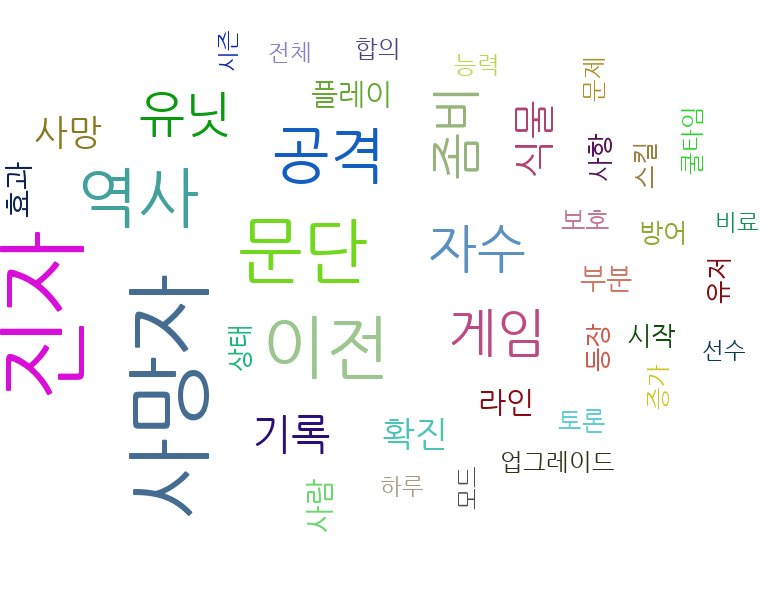

In [21]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')

# [나무위키 키워드 시각화]

# 제목 키워드

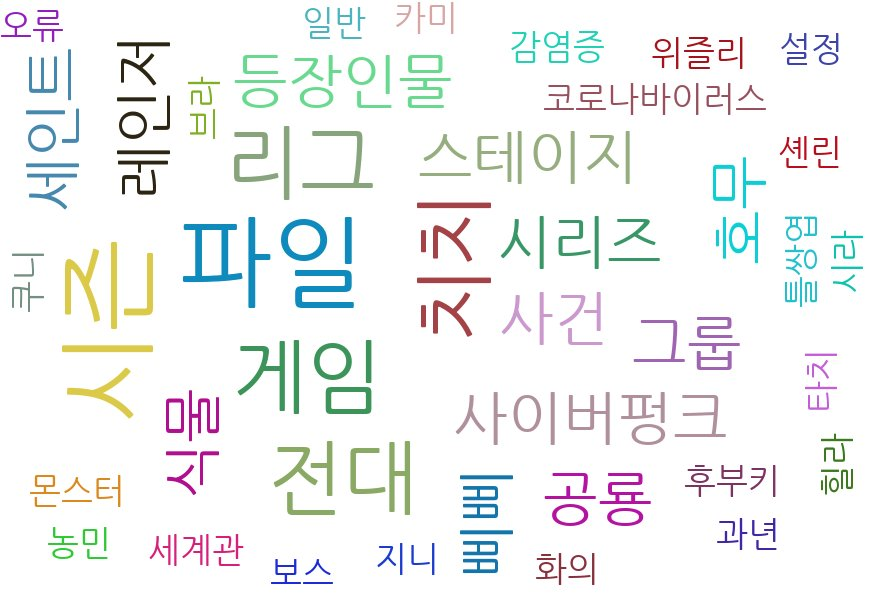

In [22]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

# 카테고리 키워드

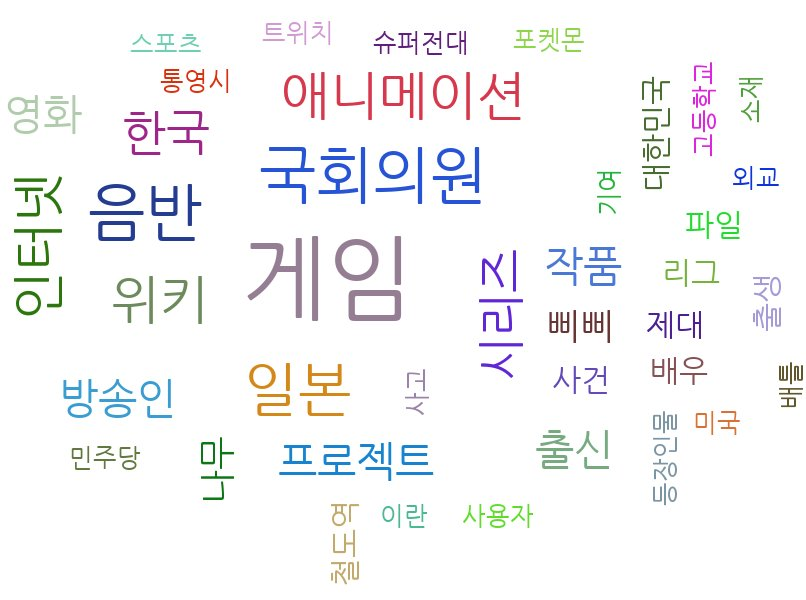

In [23]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')